# Reinforcement Learning

## Lunar lander

#### Liberaries

In [1]:
import numpy as np
import random
import LunarUtils
# deque is our data structure for our memory buffer
from collections import deque, namedtuple
# namedtuple used to store experience tuple

In [2]:
import gymnasium as gym
# gym is environment liberary used in reinforcement to test the reinforcement learning algorithm
import time

In [3]:
# PIL and pyvirtualdisplay used to render the lunar lander environment
from PIL import Image
from pyvirtualdisplay import Display

In [4]:
# tensorflow liberaries for the neural network
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [5]:
# set the virtual display for lunar lander environment
# Display(visible=0, size=(840, 480)).start();
# set the random seed for tensorflow
tf.random.set_seed(42)

In [6]:
# set the hyperparameter values used for reinforcement environment
MEMORY_SIZE = 100_000 # size of memory buffer
GAMMA = 0.995 # discount factor
ALPHA = 1e-3 # learning rate
TAU = 1e-3 # soft update
NUM_STEP_FOR_UPDATE = 4 # perform a learning step after c time

#### Lunar lander Environment

> lunar lander can do four actions : 0. do nothing, 1. fire left engine 2. fire main engine 3. fire right engine

> the environment considered solved if the lunar lander gets 200 points

#### Observation space

agent's observation space contains 8 parameters

* (x, y) coordinates in space
* $(\dot x, \dot y)$ velocity in x and y direction
* $\theta$ angle
* $\dot \theta$ angular velocity
* l and r, which represent that each leg of lunar lender is on the groud or not

In [7]:
# load the environment
env = gym.make('LunarLander-v3',  render_mode="rgb_array")

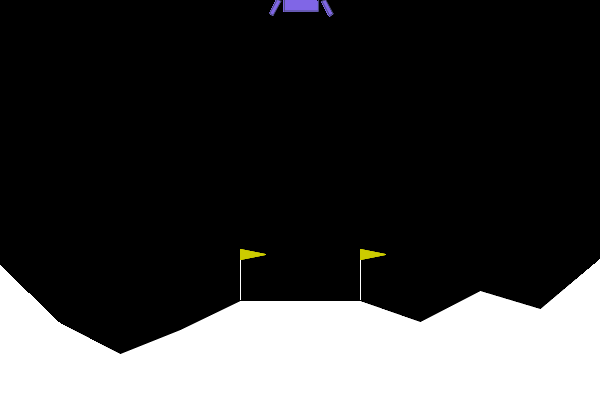

In [8]:
# reset the environment
env.reset()
# render the first image of the environment
Image.fromarray(env.render())

In [9]:
# now get the size of state vector and no. of actions
state_size = env.observation_space.shape
num_action = env.action_space.n
print("size of state vector: ", state_size)
print("no. of actions: ", num_action)

size of state vector:  (8,)
no. of actions:  4


#### Interacting with gym environment

 `.step()` method in gym liberary take action and return four values

* observation : a numpy array containing velocities and position of lunar lander
* reward : amount of reward return as result after taking an action
* done(boolean) : done return a boolean value if its true then it show that current episode is terminated, reset the environment
* info : information use for debugging

In [10]:
# reset the environment to get the current state
current_state = env.reset()

In [11]:
# select an action
action = 0 # do nothing

# on give action run the step function
next_state, reward, done, _, _ = env.step(action)

# print the obseravation
print("current state : ", current_state)
print("next state : ", next_state)
print("reward : ", reward)
print("done : ", done)

# assign next_state to current state
current_state = next_state

current state :  (array([ 0.00204124,  1.4213156 ,  0.20674613,  0.46202615, -0.00235855,
       -0.046831  ,  0.        ,  0.        ], dtype=float32), {})
next state :  [ 0.00408258  1.4311326   0.2064666   0.43630913 -0.00467255 -0.04628339
  0.          0.        ]
reward :  1.134400110817694
done :  False


### Deep Q-Learning

using neural network for the reinforcement learning is highly unstable, but using some technique the unstability can be avoided, these techniques are

1. Target Network
2. Experience Replay

#### 1. Target Network

the target y is variable at every iteration, so we need two neural network one for target, and one for output

In [12]:
# Q-network
q_network = Sequential([
    # input layer
    Input(shape=(state_size)),
    # first hidden layer
    Dense(units=64, activation='relu'),
    # second hidden layer
    Dense(units=64, activation='relu'),
    # output layer
    Dense(units=num_action, activation='linear')
])

# target-Q-network
target_q_network = Sequential([
    # input layer
    Input(shape=(state_size)),
    # first hidden layer
    Dense(units=64, activation='relu'),
    # second hidden layer
    Dense(units=64, activation='relu'),
    # output layer
    Dense(units=num_action, activation='linear')
])

# cost
optimizer = Adam(learning_rate=ALPHA)

#### 2. Experience Replay

in experience replay, we store previous obeservations like $(S_t, A_t, R_t, S_{t+1})$ in the memory buffer, after we select the random min batch of experience from the buffer

In [13]:
# store the experience as name tuple
Experience = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done"])

### Deep Q-Learning with Experience Replay

In [14]:
# first compute the loss between y_target and q_value
def compute_loss(experiences, gamma, q_network, target_q_network):
    '''
    # inputs
    experiences : namedtuple that contains the experience replay
    gamma : discount factor
    q_network : keras model to generate q_values
    target_q_network : keras model to generate y_target

    # output
    loss : mean squared error between q_values and y_target
    '''

    # unpack min batch of experience tuple
    states, actions, rewards, next_states, done_vals = experiences

    # comput max Q(s, a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis = -1)

    # find the y target value
    y_target = rewards + (1 - done_vals)*(max_qsa*gamma)

    # get the q_values and reshape to match the y_target
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # compute loss
    loss = MSE(q_values, y_target)
    return loss

#### update the network weights

In [15]:
# agent learn method update the weights of q_network and target_q_network using custom training loop
@tf.function
def agent_learn(experience, gamma):
    # update the weights of Q network
    # calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experience, gamma, q_network, target_q_network)

    # get the gradient of the loss w.r.t the weights
    gradient = tape.gradient(loss, q_network.trainable_variables)

    # update the weight of q_network
    optimizer.apply_gradients(zip(gradient, q_network.trainable_variables))

    # update the weight of target_q_network
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

### Train the Agent

In [16]:
start = time.time()

# number of episodes
num_episodes = 2000
# max number of steps a agent can take during an episode
max_num_timestamps = 1000
# store the history of points rewards
total_point_history = []

# min batch size
MINIBATCH_SIZE = 64
# number of total points use for averaging
num_p_av = 100
# initialize Epsilon for E-greedy policy
epsilon = 1.0

# create  a memory buffer
memory_buffer = deque(maxlen = MEMORY_SIZE)

# set the target_q_network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    # reset the environment state
    state = env.reset()[0]
    total_points = 0

    for t in range(max_num_timestamps):
        # from the current state S choose the action A using e greedy policy
        state_q = np.expand_dims(state, axis = 0)
        q_values = q_network(state_q)
        if random.random() > epsilon:
            action = np.argmax(q_values.numpy()[0])
        else:
            action = random.choice(list(np.arange(4)))

        # step method to get the observation
        next_state, reward, done, _, _ = env.step(action)

        # store the experience tuple in the memory_buffer
        memory_buffer.append(Experience(state, action, reward, next_state, done))

        # update the nework
        if (t + 1) % NUM_STEP_FOR_UPDATE == 0 and len(memory_buffer) > MINIBATCH_SIZE:
            # sample random mini batch experience from memory_buffer
            experience = LunarUtils.get_experiences(memory_buffer)
            # set the y_target and update the weights
            agent_learn(experience, GAMMA)

        # copy the next state to current
        state = next_state.copy()
        total_points += reward
        
        # Live render every 100 episodes
        if i % 100 == 0:
            env.render()
            time.sleep(0.01)  # Adjust speed of rendering
            
        # if done is true then break
        if done:
            break
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = LunarUtils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -166.78
Episode 200 | Total point average of the last 100 episodes: -93.311
Episode 300 | Total point average of the last 100 episodes: -29.69
Episode 400 | Total point average of the last 100 episodes: 76.585
Episode 500 | Total point average of the last 100 episodes: 134.78
Episode 600 | Total point average of the last 100 episodes: 185.37
Episode 630 | Total point average of the last 100 episodes: 198.47

Episode 631 | Total point average of the last 100 episodes: 201.23

Environment solved in 631 episodes!

Total Runtime: 1720.22 s (28.67 min)


### See the trained Agent In action

In [63]:
# using open cv to rendering the agent interacting with environment
import cv2

# Create the Lunar Lander environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")

num_episodes = 20  # Change this to run more episodes
for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_q = np.expand_dims(state, axis = 0)
        q_values = q_network(state_q)
        action = np.argmax(q_values.numpy()[0]) 
        state, reward, done, _, _ = env.step(action)
        total_reward += reward

        # Render the frame
        frame = env.render()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV format)

        # Display the frame
        cv2.imshow("Lunar Lander - performance", frame)
        
        if cv2.waitKey(10) & 0xFF == ord("q"):  # Press 'q' to quit
            break

    print(f"Episode {episode + 1} finished with Total Reward: {total_reward:.2f}")
    time.sleep(1)  # Pause before the next episode

# Close the OpenCV window and environment
env.close()
cv2.destroyAllWindows()


Episode 1 finished with Total Reward: 246.03
Episode 2 finished with Total Reward: 66.74
Episode 3 finished with Total Reward: -2.68
Episode 4 finished with Total Reward: 1.59
Episode 5 finished with Total Reward: 0.90
Episode 6 finished with Total Reward: -0.64
Episode 7 finished with Total Reward: -0.17
Episode 8 finished with Total Reward: 0.98
Episode 9 finished with Total Reward: -0.35
Episode 10 finished with Total Reward: -1.60
Episode 11 finished with Total Reward: 0.15
Episode 12 finished with Total Reward: 0.16
Episode 13 finished with Total Reward: -0.02
Episode 14 finished with Total Reward: -1.88
Episode 15 finished with Total Reward: 1.55
Episode 16 finished with Total Reward: 0.89
Episode 17 finished with Total Reward: 1.19
Episode 18 finished with Total Reward: -0.22
Episode 19 finished with Total Reward: -0.89
Episode 20 finished with Total Reward: -1.12
